In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import fsolve
from scipy.linalg import cho_solve, cho_factor
from scipy.interpolate import interp1d

## 1. Define S(Q,t) function

In [155]:
def f_sqt_chain(Q, t, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm^1 (default 50)

    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """

    # Indices for polymer beads
    n_values, m_values = np.meshgrid(np.arange(N), np.arange(N))
    abs_nm = np.abs(n_values - m_values)

    # Compute Phi_nm(t) components
    Phi_D = 6 * D * t  # Center-of-mass diffusion
    Phi_nm_0 = abs_nm * b**2  # Gaussian chain contribution

    # Compute Phi_nm^1 (dynamic part)
    Phi_nm_1 = ((4 * N * b**2 / np.pi**2) * 
                np.sum([(1 / p**2) * np.einsum('kl,ij->ijkl', 
                                               np.cos(p * np.pi * n_values / N) * np.cos(p * np.pi * m_values / N), 
                                               (1 - np.exp(-t * p**2 / tau_R))) 
                        for p in range(1, p_max+1)], # sum over p
                       axis=0))
    
    # Total Phi_nm
    Phi_nm = Phi_D[:, :, None, None] + Phi_nm_0[None, None, :, :] + Phi_nm_1
    
    # Compute S(Q, t) using einsum
    Q_squared = Q**2  # Shape [i, j]
    Q_squared_expanded = Q_squared[:, :, None, None]  # Shape [i, j, 1, 1]
    sqt = (1 / N) * np.einsum('ijkl,ijkl->ij', np.exp(- (1/6) * Q_squared_expanded * Phi_nm), np.ones_like(Phi_nm))


    return sqt


### Calculate S(Q, t) for a range of Q and t values

In [156]:
n_Q = 21
n_t = 33

t = (np.arange(n_t))/n_t*12
t = 10**(np.linspace(-3,1, n_t))
b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

QRg = np.linspace(0, 4, n_Q)
Q = QRg/Rg

Q_grid, t_grid = np.meshgrid(QRg, t)

sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/(n_Q-1)


0.7720312888245996
9.775558833107173 0.9431219826620749
a_fit: 9.947319525631446, b_fit: 0.9521247245594537
0.42705608480269275
1.7854713493978083 0.8728840044397173
a_fit: 1.9424545983605945, b_fit: 0.805844217611972
0.23120891294011225
nan nan
a_fit: 0.5049577709178336, b_fit: 0.7259690514746334
0.13498304896748958
nan nan
a_fit: 0.16935636847713617, b_fit: 0.7754134128424462


/tmp/ipykernel_1846883/2326923677.py:45: RuntimeWarning: invalid value encountered in log
  Y_1 = np.log(-np.log(st_poly_fit/s0_fit))
/tmp/ipykernel_1846883/2326923677.py:57: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x/a)**b)


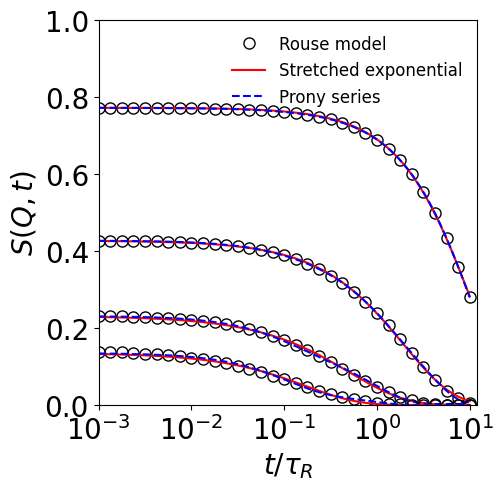

In [157]:
from scipy.optimize import curve_fit

# Define the stretched exponential function
def f_sexp(t, s0, tau, beta):
    return s0 * np.exp(- (t / tau) ** beta)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for index_Q in [5, 10, 15, 20]:
    st_test = sqt[:,index_Q]
    s0_test = st_test[0]
    st_test = st_test
    # t = (np.arange(n_t))/n_t*5

    # t = np.logspace(-3, 1, 33)
    # st_test = f_sexp(t, s0=1, tau=1, beta=0.75)


    # Ensure `t` is correctly filtered
    valid_mask = t > 0  # Boolean mask
    t_valid = t[valid_mask]  # Filter only valid t values
    st_valid = st_test[valid_mask]  # Corresponding s(t) values

    t_fine = np.logspace(-3, 1, 1000)

    N_Prony = 5
    list_tau_i = 10**(np.linspace(-1,3,N_Prony))

    # Construct the X matrix for Prony series
    X = np.column_stack([np.exp(-t_valid/tau) for tau in list_tau_i])
    X_fine = np.column_stack([np.exp(-t_fine/tau) for tau in list_tau_i])

    Y = st_valid
    # Solve Y = AX using least squares
    A = np.linalg.lstsq(X, Y, rcond=None)[0]
    st_poly_fit = A@X.T
    st_poly_fit_fine = A@X_fine.T

    # Determine S0
    s0_fit = np.sum(A)
    print(s0_fit)

    # Determine tau and beta
    Y_1 = np.log(-np.log(st_poly_fit/s0_fit))
    X_1 = np.column_stack([np.log(t_valid), np.ones_like(t_valid)])
    X_1_fine = np.column_stack([np.log(t_fine), np.ones_like(t_fine)])
    A_1 = np.linalg.lstsq(X_1, Y_1, rcond=None)[0]

    beta_fit = A_1[0]
    tau_fit = np.exp(-A_1[1]/beta_fit)
    print(tau_fit, beta_fit)

    # Fit -np.log(st_poly_fit/s0_fit) and t_valid using the relation y=exp(-(ax)**b)
    # Define the fitting function
    def exp_func(x, a, b):
        return np.exp(-(x/a)**b)

    # Perform the curve fitting
    popt, pcov = curve_fit(exp_func, t_valid, st_valid/s0_fit)

    # Extract the fitting parameters
    a_fit, b_fit = popt
    print(f"a_fit: {a_fit}, b_fit: {b_fit}")

    # Generate fitted s(t) values
    st_exp_fit = f_sexp(t_valid, s0_fit, tau_fit, beta_fit)
    st_exp_fit_fine = f_sexp(t_fine, s0_fit, tau_fit, beta_fit)
    st_exp_fit_fine = f_sexp(t_fine, s0_fit, a_fit, b_fit)


    # ax.set_title('Prony Series', fontsize=20)
    if index_Q==5:
        label_data = "Rouse model"
        label_sexp = "Stretched exponential"
        label_prony = "Prony series"
    else:
        label_data = None
        label_sexp = None
        label_prony = None
    ax.plot((t_valid), st_valid, 'o', label=label_data, color="black", fillstyle='none', markersize= 8)
    ax.plot((t_fine), st_exp_fit_fine, label=label_sexp, linestyle="solid", color="red")
    ax.plot((t_fine), st_poly_fit_fine, label=label_prony, linestyle="dashed", color="blue")

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$t/\tau_R$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([0, 1])
ax.set_xlim([8e-3, 1.2e1])
ax.set_aspect(4.15/1)
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

ax.legend(frameon=False, fontsize=12, loc='upper right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


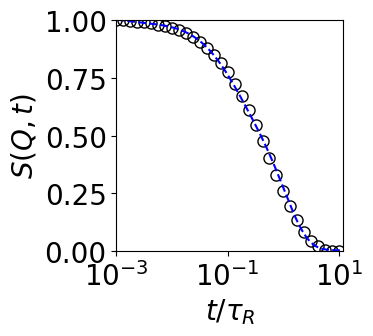

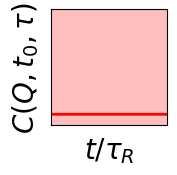

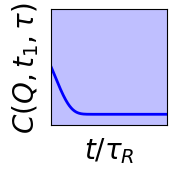

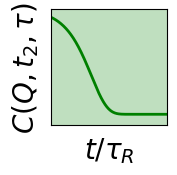

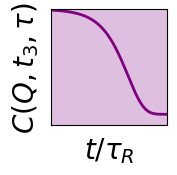

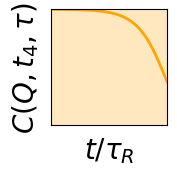

In [158]:
# Define the stretched exponential function
def f_sexp(t, s0, tau, beta):
    return s0 * np.exp(- (t / tau) ** beta)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)

st_test = sqt[:,14]
s0_test = st_test[0]
st_test = st_test/s0_test
# t = (np.arange(n_t))/n_t*5

# t = np.logspace(-3, 1, 33)
# st_test = f_sexp(t, s0=1, tau=1, beta=0.75)


# Ensure `t` is correctly filtered
valid_mask = t > 0  # Boolean mask
t_valid = t[valid_mask]  # Filter only valid t values
st_valid = st_test[valid_mask]  # Corresponding s(t) values

t_fine = np.logspace(-3, 4, 1000)

N_Prony = 5
list_tau_i = 10**(np.linspace(-3,1,N_Prony))

# Construct the X matrix for Prony series
X = np.column_stack([np.exp(-t_valid/tau) for tau in list_tau_i])
X_fine = np.column_stack([np.exp(-t_fine/tau) for tau in list_tau_i])

Y = st_valid
# Solve Y = AX using least squares
A = np.linalg.lstsq(X, Y, rcond=None)[0]
st_poly_fit = A@X.T
st_poly_fit_fine = A@X_fine.T

XA = np.einsum('ij,j->ij', X_fine, A)

# ax.plot((t_fine), XA, '-', label=label_data, color="black", fillstyle='none', markersize= 8)
ax.plot((t_valid), st_valid, 'o', label=label_data, color="black", fillstyle='none', markersize= 8)
# ax.plot((t_fine), st_exp_fit_fine, label=label_sexp, linestyle="solid", color="red")
ax.plot((t_fine), st_poly_fit_fine, label=label_prony, linestyle="dashed", color="blue")

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$t/\tau_R$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([0, 1])
ax.set_xlim([8e-3, 1.2e1])
ax.set_aspect(4.15/1)
ax.set_xticks([1e-3, 1e-1, 1e1])

ax.legend(frameon=False, fontsize=12, loc='upper right')

colors = ['red', 'blue', 'green', 'purple', 'orange']
for i, basis in enumerate(X_fine.T):
    fig = plt.figure(figsize=(1.5,1.5))
    ax = fig.add_subplot(111)
    ax.plot(t_fine, basis, linestyle='-', color=colors[i], lw=2)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(r'$t/\tau_R$', fontsize=20)
    ax.set_ylabel(r'$C(Q,t_{},\tau)$'.format(i), fontsize=20)
    # ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([-0.1, 1])
    ax.set_xlim([8e-3, 1.2e1])
    # ax.set_aspect(4.15/1)
    color = np.array(matplotlib.colors.to_rgba(colors[i]))
    color[3] = 0.25
    ax.set_facecolor(color)

In [159]:
color[3]

0.25

### Generate random distribured detector counts

In [160]:
def f_sqt_sample_t(Q, t, N_count=1000, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10, seed=None, bg = 0.01):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N_count (int): Number of counts for each Q (default 1000)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm_1 (default 50)
    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """
    
    np.random.seed(seed)
    sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/n_Q
    Delta_sqt_sample = np.zeros((n_t, n_Q))
    sqt_sample = np.zeros((n_t, n_Q))
    for i in range(QRg.shape[0]):
        fit = (sqt)[:,i]+bg
        pit = fit/np.sum(fit)
        Nit = N_count*pit
        Delta_fit = np.sqrt(Nit)/N_count*np.sum(fit)
        Delta_sqt_sample[:,i] = Delta_fit
        
        bin_edges = np.linspace(0, len(t), len(t)+1)
        indices = np.random.choice(len(t), size=int(N_count), p=pit)
        N_sample_i, _ = np.histogram(indices, bins=bin_edges)
        sqt_sample_i = N_sample_i/N_count*np.sum(fit)
        sqt_sample[:,i] = sqt_sample_i
        
    return sqt_sample, Delta_sqt_sample, sqt+bg

def f_sqt_sample_Qt(Q, t, N_count=1000, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10, seed=None, bg = 0.01):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N_count (int): Number of counts for each Q (default 1000)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm_1 (default 50)
    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """
    
    np.random.seed(seed)
    sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/n_Q+bg
    
    pqt = sqt/np.sum(sqt)
    Nqt = N_count*pqt
    Delta_sqt = np.sqrt(Nqt)/N_count*np.sum(sqt)
    Delta_sqt_sample = Delta_sqt
    
    
    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(t_grid.flatten()), size=N_count, p=pqt.flatten())
    
    # Get the sampled t and Q values    
    sqt_sample = np.zeros((n_t, n_Q))
    for i in range(len(indices)):
        t_index = indices[i] // n_Q
        Q_index = indices[i] % n_Q
        sqt_sample[t_index, Q_index] += 1
    sqt_sample = sqt_sample/N_count*np.sum(sqt)
    
    # for i in range(QRg.shape[0]):
    #     fit = (sqt)[:,i]+bg
    #     pit = fit/np.sum(fit)
    #     Nit = N_count*pit
    #     Delta_fit = np.sqrt(Nit)/N_count*np.sum(fit)
    #     Delta_sqt_sample[:,i] = Delta_fit
        
    #     bin_edges = np.linspace(0, len(t), len(t)+1)
    #     indices = np.random.choice(len(t), size=int(N_count), p=pit)
    #     N_sample_i, _ = np.histogram(indices, bins=bin_edges)
    #     sqt_sample_i = N_sample_i/N_count*np.sum(fit)
    #     sqt_sample[:,i] = sqt_sample_i
        
    return sqt_sample, Delta_sqt_sample, sqt

### Assign errorbar

In [188]:
bg = 0.002
N_count = n_Q*n_t*100
seed = 114514

sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_Qt(Q_grid, t_grid, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)

# N_count = n_t*100
# sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_t(Q_grid, t_grid, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)

sq0 = sqt[0,:]

## 2. Bayesian inference

In [189]:
def rbf_kernel(Q, lambda_):
    """Compute the spatial correlation kernel k_{i j}."""
    Q_i, Q_j = np.meshgrid(Q, Q, indexing='ij')
    return np.exp(-((Q_i - Q_j) ** 2) / (2 * lambda_ ** 2))

def construct_transformation_tensor(Q, t, tau, bg_mode=False):
    """Compute the transformation tensor C_{i m n}."""
    C = np.exp(-t[:, None] / tau[None, :])  # Shape (M, N)
    if bg_mode:
        C = np.hstack([np.ones((t.shape[0], 1)), C])
    return np.tile(C[None, :, :], (len(Q), 1, 1))  # Expand to (L, M, N)

def bayesian_inference(S_exp, Q, t, tau, delta_S_exp, lambda_, bg_mode=False):
    """Perform Bayesian inference to estimate A_{i n} and its covariance using einsum."""
    # L: i, j
    # M: m, p
    # N: n, q
    L, M = S_exp.shape  # L: spatial points, M: time points
    N = len(tau)  # Expansion parameter size
    if bg_mode:
        N += 1

    # Construct transformation tensor C_{i m n}
    C = construct_transformation_tensor(Q, t, tau, bg_mode)  # Shape (L, M, N)

    # Construct spatial covariance K_{i j}
    K = rbf_kernel(Q, lambda_)  # Shape (L, L)

    # Construct noise covariance Sigma_{i m, j m}
    Sigma = np.einsum('im,ij,mp->imjp', delta_S_exp**2, np.eye(L), np.eye(M))  # Shape (L, M, L, M)

    # Expand K to K_{i n, j q} using Kronecker product property
    K_expanded = np.einsum('ij,nq->injq', K, np.eye(N))  # Shape (L, N, L, N)

    # Construct modified covariance tensor \tilde{\Sigma}_{i, m, j, p}
    Sigma_tilde = Sigma + np.einsum('imn,injq,jpq->imjp', C, K_expanded, C)  # Shape (L, M, L, M)

    # Reshape for inversion
    Sigma_tilde_reshaped = Sigma_tilde.reshape(L*M, L*M)
    Sigma_tilde_inv = cho_solve(cho_factor(Sigma_tilde_reshaped), np.eye(L*M))
    Sigma_tilde_inv = Sigma_tilde_inv.reshape(L, M, L, M)  # Restore shape

    
    K_expanded_C = np.einsum('injq, jmq->imn', K_expanded, C)  # Shape (L, M, N)
    
    # Solve for posterior mean A_GPR_{i n}
    A_GPR = np.einsum('imn,imjp,jp->in', K_expanded_C, Sigma_tilde_inv, S_exp)  # Shape (L, N)

    # Compute posterior covariance K_GPR_{i, n, j, q}
    K_GPR = K_expanded - np.einsum('imn, imjp, jpq->injq', K_expanded_C, Sigma_tilde_inv, K_expanded_C)
    
    return A_GPR, K_GPR

In [190]:
sqt_GT = sqt.T
sqt_exp = sqt_sample.T
sq0_exp = sq0.T
delta_sqt_exp = Delta_sqt_sample.T
lambda_ = 0.05

N_Prony = 5
# list_tau_i = np.exp(np.linspace(-4,2,N_Prony))
list_tau_i = 10**(np.linspace(-1,3,N_Prony))
tau = np.array(list_tau_i)
bg_mode = True

A_GPR, K_GPR = bayesian_inference(sqt_exp, Q, t, tau, delta_sqt_exp, lambda_, bg_mode)

C = construct_transformation_tensor(Q, t, tau, bg_mode)  # Shape (L, M, N)
sqt_GPR = np.einsum('ik,ijk->ij', A_GPR, C)
C_0 = construct_transformation_tensor(Q, np.array([0]), tau, bg_mode)  # Shape (L, N)
sq0_GPR = np.einsum('ik,ijk->ij', A_GPR, C_0)

K_S_GPR = np.einsum('imn,injq,jpq->imjp', C, K_GPR, C)
K_S_GPR = np.abs(K_S_GPR)
delta_sqt_GPR = np.sqrt(K_S_GPR[0,0,:,:])

## Figure: S(Q,t), 2D

/tmp/ipykernel_1846883/3758428086.py:13: UserWarning: linewidths is ignored by contourf
  ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both')
/tmp/ipykernel_1846883/3758428086.py:14: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
/tmp/ipykernel_1846883/3758428086.py:30: UserWarning: linewidths is ignored by contourf
  ax.contourf(Q_grid, t_grid, sqt_exp.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both')
/tmp/ipykernel_1846883/3758428086.py:31: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(Q_grid, t_grid, sqt_exp.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
/tmp/ipykernel_1846883/3758428086.py:47: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(Q_grid, t_grid, sqt_GPR.T, levels=np.l

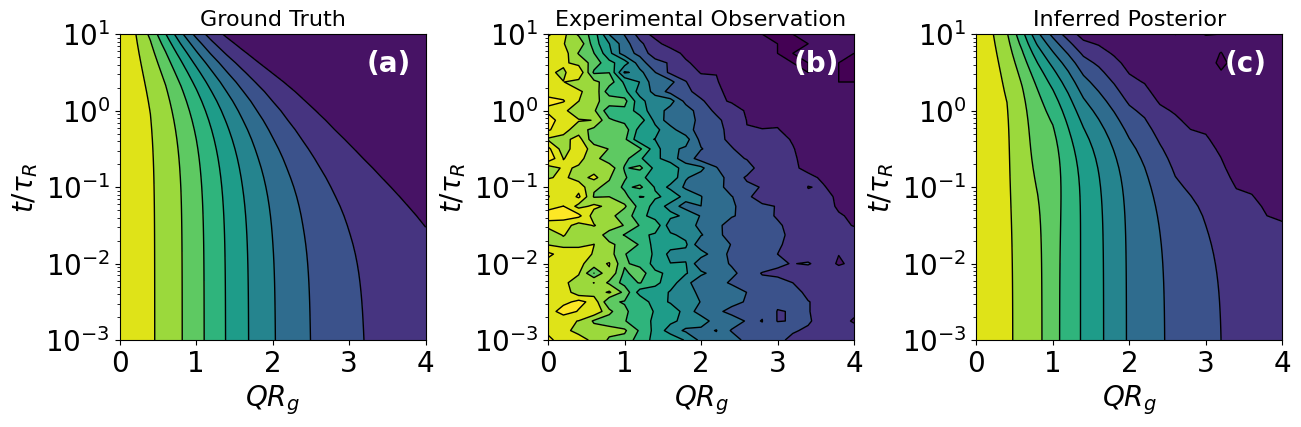

In [191]:
import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.4)
# grid = AxesGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5, cbar_mode='single', cbar_location='right', cbar_pad=0.1)

panels_list = ['(a)', '(b)', '(c)']

ax = fig.add_subplot(gs[0])
# ax = grid[0]

ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both')
ax.contour(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
ax.set_title(r'Ground Truth', fontsize=16)
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='w')
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_yscale('log')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')

ax = fig.add_subplot(gs[1])
# ax = grid[1]

ax.contourf(Q_grid, t_grid, sqt_exp.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both')
ax.contour(Q_grid, t_grid, sqt_exp.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
ax.set_title(r'Experimental Observation', fontsize=16)
ax.text(0.95, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='w')
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_yscale('log')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')

ax = fig.add_subplot(gs[2])
# ax = grid[2]

contour = ax.contourf(Q_grid, t_grid, sqt_GPR.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both')
ax.contour(Q_grid, t_grid, sqt_GPR.T, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
ax.set_title(r'Inferred Posterior', fontsize=16)
ax.text(0.95, 0.95, panels_list[2], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='w')
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_yscale('log')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')

# cbar = grid.cbar_axes[0].colorbar(contour)
# cbar.ax.tick_params(labelsize=16)
# cbar.set_ticks(np.linspace(0, 1, 11))
# cbar.formatter.set_powerlimits((0, 0))
# cbar.ax.yaxis.offsetText.set(size=16)


/tmp/ipykernel_1846883/3904478019.py:3: UserWarning: linewidths is ignored by contourf
  c = ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1)
/tmp/ipykernel_1846883/3904478019.py:4: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)


Text(0.5, 1.0, '$S(Q, t)$')

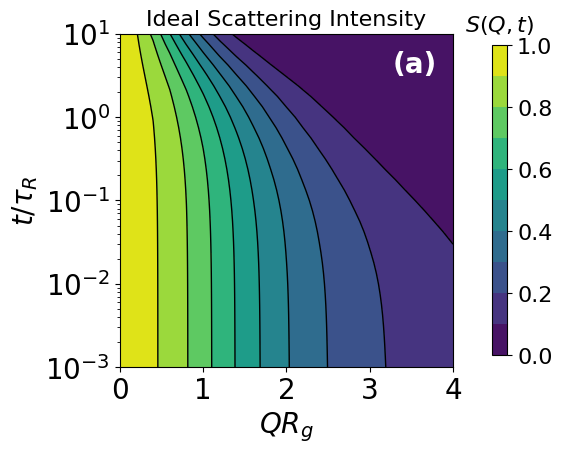

In [192]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
c = ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1)
ax.contour(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), zorder=-1, linewidths=1, extend='both',colors='k',lw=2)
ax.set_title(r'Ideal Scattering Intensity', fontsize=16)
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='w')
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_yscale('log')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')

cbar = fig.colorbar(c, ax=ax, fraction=0.04, pad=0.1)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title(r'$S(Q, t)$', fontsize=16, pad=10)


## FigureL S(Q) and S(t)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


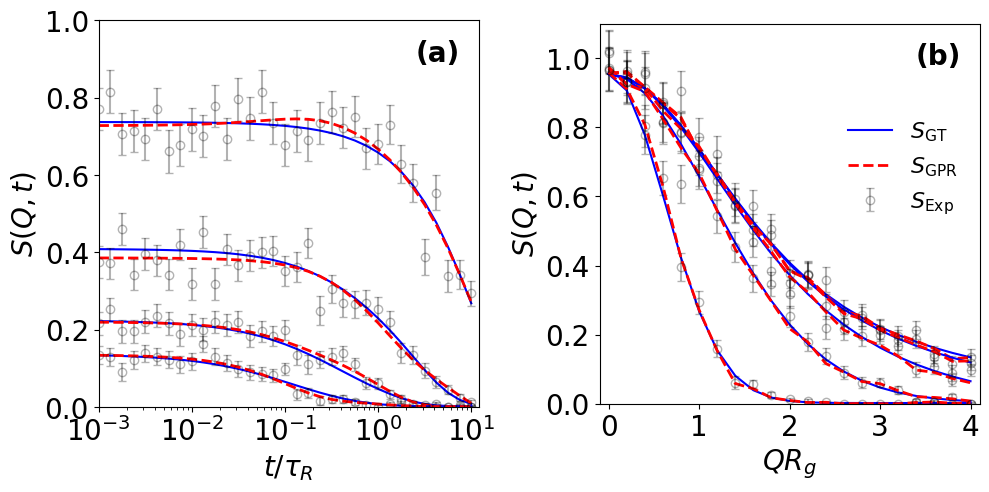

In [193]:
# 1D results of each Q
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.4)

ax = fig.add_subplot(121)

# colors = plt.cm.viridis(np.linspace(0, 1, len(Q)))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
colors = ['k','k','k','k','k']

i_color = 0
for i_q, q_plot in enumerate(QRg):
    if q_plot in [1, 2, 3, 4]:
        ax.plot(t, (sqt_GT[i_q, :]), '-b')
        # ax.plot(t, (sqt_exp[i_q, :]), 'o', color=colors[i_color], alpha = 0.5, fillstyle='none')
        ax.errorbar(t, (sqt_exp[i_q, :]), yerr=(delta_sqt_exp[i_q, :]), fmt='ok', ecolor=colors[i_color], capsize=3, alpha = 0.3, fillstyle='none')
        ax.plot(t, (sqt_GPR[i_q, :]), '--', color='r', lw=2)
        # ax.fill_between(t, (sqt_GPR-delta_sqt_exp)[i_q, :], (sqt_GPR+delta_sqt_exp)[i_q, :], color='r', alpha=0.2)
        i_color += 1
    
ax.set_xlabel(r'$t/\tau_R$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([-0.0, 1.0])
ax.set_xlim([8e-3, 1.2e1])

# ax.set_yscale('log')
# ax.set_ylim([1e-2, 2])
ax.set_xscale('log')
ax.legend(fontsize=12, frameon=False, ncol=2)
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')
ax.set_aspect(4.15/1.0)
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

# 1D results of each t
ax = fig.add_subplot(122)

# colors = plt.cm.viridis(np.linspace(0, 1, len(t)))

i_color = 0
for i_t, t_plot in enumerate(t):
    if i_t in np.array([0, 1, 2, 3, 4])*8:
        if i_color == 0:
            label_GT = r'$S_\mathrm{GT}$'
            label_exp = r'$S_\mathrm{Exp}$'
            label_GPR = r'$S_\mathrm{GPR}$'
        else:
            label_GT = None
            label_exp = None
            label_GPR = None
        ax.plot(QRg, (sqt_GT[:, i_t]), '-b', label = label_GT)
        # ax.plot(QRg, (sqt_exp[:, i_t]), 'o', color=colors[i_color], alpha = 0.5, fillstyle='none')
        ax.errorbar(QRg, (sqt_exp[:, i_t]), yerr=(delta_sqt_exp[:, i_t]), fmt='ok', ecolor=colors[i_color], capsize=3, alpha = 0.3, fillstyle='none', label = label_exp)
        ax.plot(QRg, (sqt_GPR)[:, i_t], '--', color='r', lw=2, label = label_GPR)
        # ax.fill_between(QRg, (sqt_GPR-delta_sqt_exp)[:, i_t], (sqt_GPR+delta_sqt_exp)[:, i_t], color='r', alpha=0.2)
        i_color += 1
    
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([-0.0, 1.1])
ax.set_xlim([-0.1, 4.1])
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 2])
# ax.set_xscale('log')
ax.set_xticks([0, 1, 2, 3, 4])
ax.text(0.95, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')
ax.set_aspect(4.2/1.1)
ax.legend(fontsize=16, frameon=False, bbox_to_anchor=(0.6, 0.8), loc='upper left')

plt.tight_layout()

## Figure: 3D scatter plot and surf plot

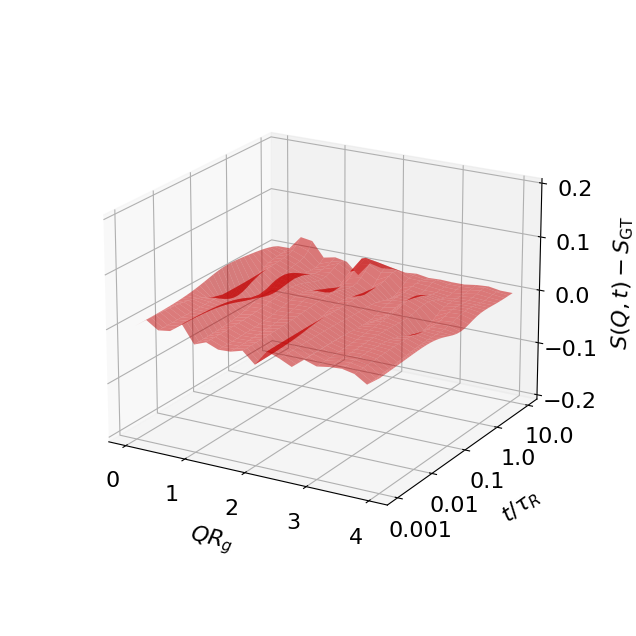

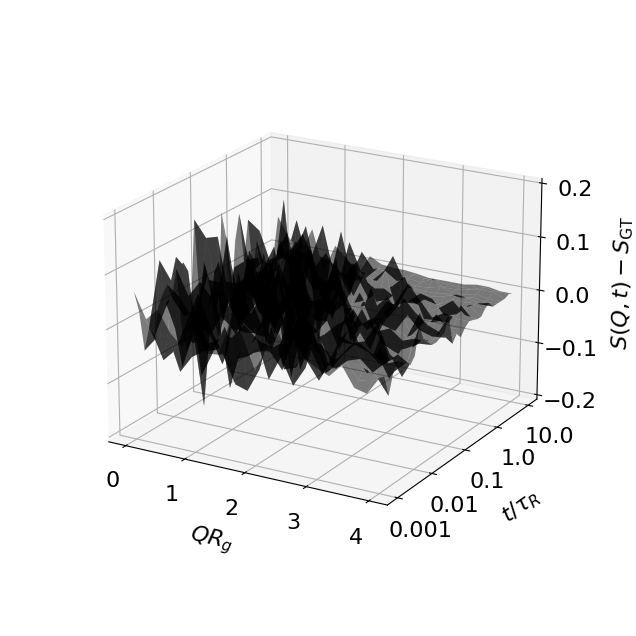

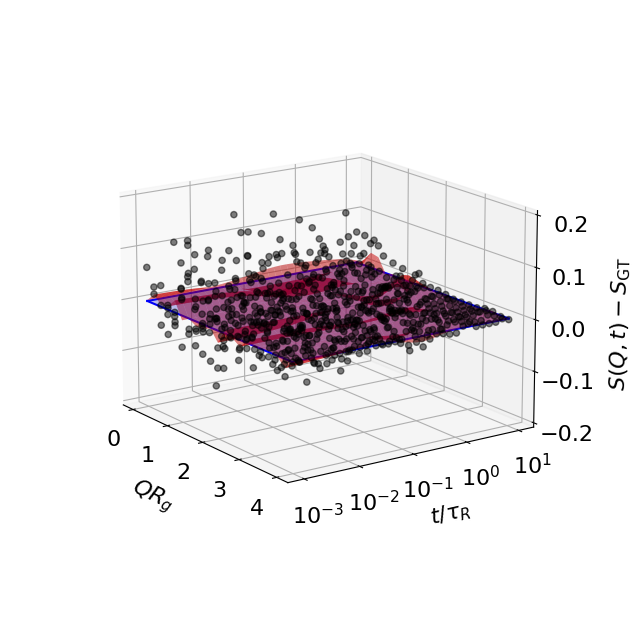

In [194]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16, 8))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

err_exp = ((sqt_exp.T-sqt_GT.T))
err_GPR = ((sqt_GPR.T-sqt_GT.T))
# Plot for sqt_GPR
X_append = np.append(Q_grid, Q_grid, axis=0)
Y_append = np.append(np.log10(t_grid), np.log10(t_grid), axis=0)
Z_append = np.append(err_exp, err_GPR, axis=0)
col1 = np.full(sqt_GPR.T.shape, 'k', dtype='U50')
col2 = np.full(sqt_GPR.T.shape, 'r', dtype='U50')
surf_gpr = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GPR.T-sqt_GT.T, color='r', alpha=0.5)
# surf_exp = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)
# surf = ax.plot_surface(X_append, Y_append, Z_append, facecolors= np.append(col1, col2, axis=0), alpha=0.2)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)-S_\mathrm{GT}$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([1e-3, 1e-2, 1e-1, 1e0, 1e1])

ax.set_xticks([0, 1, 2, 3, 4])

ax.set_zticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.8)

ax.view_init(20, 300)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

err_exp = ((sqt_exp.T-sqt_GT.T))
err_GPR = ((sqt_GPR.T-sqt_GT.T))
# Plot for sqt_GPR
X_append = np.append(Q_grid, Q_grid, axis=0)
Y_append = np.append(np.log10(t_grid), np.log10(t_grid), axis=0)
Z_append = np.append(err_exp, err_GPR, axis=0)
col1 = np.full(sqt_GPR.T.shape, 'k', dtype='U50')
col2 = np.full(sqt_GPR.T.shape, 'r', dtype='U50')
# surf_gpr = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GPR.T-sqt_GT.T, color='r', alpha=0.5)
surf_exp = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)
# surf = ax.plot_surface(X_append, Y_append, Z_append, facecolors= np.append(col1, col2, axis=0), alpha=0.2)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)-S_\mathrm{GT}$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([1e-3, 1e-2, 1e-1, 1e0, 1e1])

ax.set_xticks([0, 1, 2, 3, 4])

ax.set_zticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.8)

ax.view_init(20, 300)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

err_exp = ((sqt_exp.T-sqt_GT.T))
err_GPR = ((sqt_GPR.T-sqt_GT.T))
# Plot for sqt_GPR
X_append = np.append(Q_grid, Q_grid, axis=0)
Y_append = np.append(np.log10(t_grid), np.log10(t_grid), axis=0)
# Z_append = np.append(err_exp, err_GPR, axis=0)
Z_append = np.append(err_exp*0, err_GPR, axis=0)
# col1 = np.full(sqt_GPR.T.shape, 'k', dtype='U50')
col1 = np.full(sqt_GPR.T.shape, 'b', dtype='U50')
col2 = np.full(sqt_GPR.T.shape, 'r', dtype='U50')
surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T-sqt_GT.T, color='b', alpha=0.25)
# surf = ax.plot_surface(X_append, Y_append, Z_append, facecolors=np.append(col1, col2, axis=0), alpha=0.2)
surf_gpr = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GPR.T-sqt_GT.T, color='r', alpha=0.5, label='GPR')
# surf_exp = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)


ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)
        
ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)-S_\mathrm{GT}$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])

ax.set_zticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

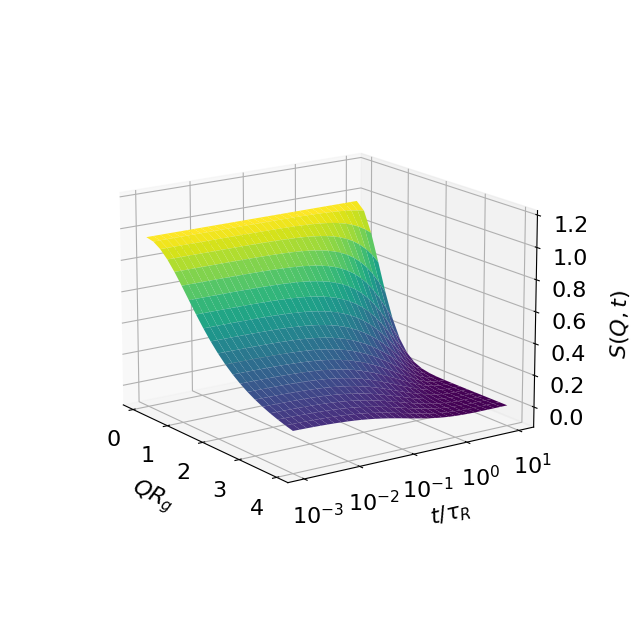

In [196]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
# ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T, c=sqt_GT.T, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

## Figure: MSE_count

In [150]:
n_repeat = 8
list_N_count = np.logspace(2.5,5.5,16)
list_chi_sq_exp_gt = []
list_chi_sq_GPR_gt = []
list_mse_exp_gt = []
list_mse_GPR_gt = []
for N_count in list_N_count:
    mse_exp_gt = 0
    mse_GPR_gt = 0
    chi_sq_exp_gt = 0
    chi_sq_GPR_gt = 0
    for i in range(n_repeat):
        sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_t(Q_grid, t_grid, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=None, bg = bg)
        sqt_GT = sqt.T
        sqt_exp = sqt_sample.T
        delta_sqt_exp = Delta_sqt_sample.T
        A_GPR, K_GPR = bayesian_inference(sqt_exp, Q, t, tau, delta_sqt_exp, lambda_, bg_mode)
        C = construct_transformation_tensor(Q, t, tau, bg_mode)  # Shape (L, M, N)
        sqt_GPR = np.einsum('ik,ijk->ij', A_GPR, C)
        C_0 = construct_transformation_tensor(Q, np.array([0]), tau, bg_mode)  # Shape (L, N)
        sq0_GPR = np.einsum('ik,ijk->ij', A_GPR, C_0)
    
        mse_exp_gt += np.mean((sqt_exp-sqt_GT)**2)
        mse_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2)
        
        chi_sq_exp_gt += np.mean((sqt_exp-sqt_GT)**2/delta_sqt_exp**2)
        chi_sq_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2/delta_sqt_exp**2)
    
    mse_exp_gt /= n_repeat
    mse_GPR_gt /= n_repeat
    chi_sq_exp_gt /= n_repeat
    chi_sq_GPR_gt /= n_repeat
    
    list_chi_sq_exp_gt.append(chi_sq_exp_gt)
    list_chi_sq_GPR_gt.append(chi_sq_GPR_gt)
    list_mse_exp_gt.append(mse_exp_gt)
    list_mse_GPR_gt.append(mse_GPR_gt)
    


In [151]:
# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(np.log(list_mse_GPR_gt), np.log(list_N_count), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(list_N_count)
for i in range(len(list_mse_exp_gt)):
    H_exp_gt_i = np.log(list_mse_exp_gt[i])
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

In [152]:
from scipy.optimize import curve_fit

# plot the time required for the GPR and the experimental data to reach the same relative entropy
# fit the log(list_N_count) - log(list_mse_GPR_gt) with a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the data for GPR
popt_gpr, pcov_gpr = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_GPR_gt))
# Generate x values for the fitted line
x_fit_gpr = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_gpr = linear_func(x_fit_gpr, *popt_gpr)

# Fit the data for Exp
popt_exp, pcov_exp = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_exp_gt))
# Generate x values for the fitted line
x_fit_exp = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_exp = linear_func(x_fit_exp, *popt_exp)

# Estimate the x_fit_gpr and x_fit_exp given the same y
y_target_values = np.linspace(np.min(np.log(list_mse_GPR_gt)), np.max(np.log(list_mse_GPR_gt)), 10)
y_target_values = np.log(list_mse_GPR_gt)

N_count_est_gpr_values = []
N_count_est_exp_values = []
list_ratio_N = []

for y_target in y_target_values:
    # Find the corresponding x values for the target y value
    x_est_gpr = (y_target - popt_gpr[1]) / popt_gpr[0]
    x_est_exp = (y_target - popt_exp[1]) / popt_exp[0]

    # Convert the log values back to the original scale
    N_count_est_gpr = np.exp(x_est_gpr)
    N_count_est_exp = np.exp(x_est_exp)

    N_count_est_gpr_values.append(N_count_est_gpr)
    N_count_est_exp_values.append(N_count_est_exp)
    ratio_N = N_count_est_exp/N_count_est_gpr
    list_ratio_N.append(ratio_N)

print("Estimated N_count for GPR:", N_count_est_gpr_values)
print("Estimated N_count for Exp:", N_count_est_exp_values)

Estimated N_count for GPR: [348.7626704544084, 440.1285584307497, 680.3328100759909, 1074.5963814883573, 1830.4416242009863, 3631.409701446774, 5708.273811763019, 8296.306114660578, 13089.593620283424, 23095.3315164013, 36994.839818435634, 58004.418240028564, 82789.6621912586, 109876.71595206979, 187588.82914399626, 255718.19350989303]
Estimated N_count for Exp: [5721.351473165871, 6998.95127173897, 10206.513638532411, 15165.234228964355, 24055.93425878522, 43546.05978687002, 64432.69255690212, 89077.53594597112, 132227.52740119072, 216240.89415345466, 325227.7507661855, 480157.5901060428, 653480.6006284876, 835065.6726426593, 1327247.7969203787, 1735842.0408606492]


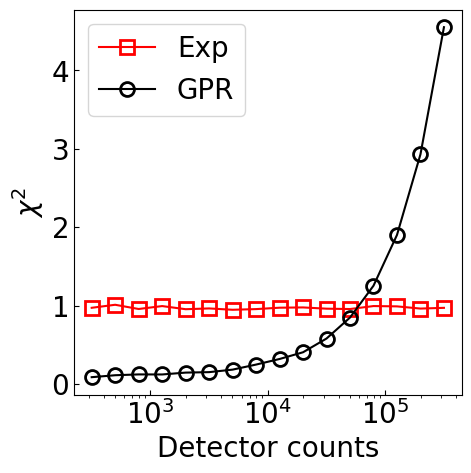

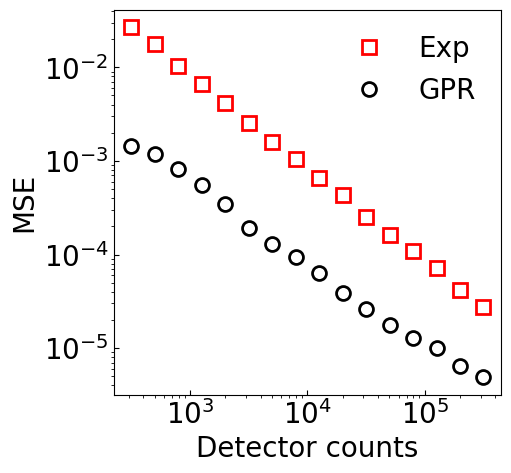

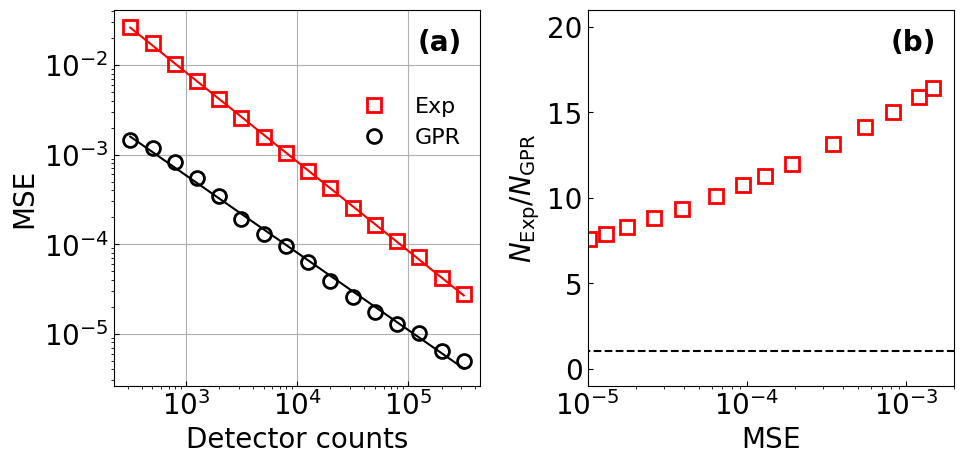

In [153]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_chi_sq_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_chi_sq_GPR_gt, '-o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel(r'$\chi^2$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20, frameon=False)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(np.exp(x_fit_exp), np.exp(y_fit_exp), '-', color='r',  fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.plot(np.exp(x_fit_gpr), np.exp(y_fit_gpr), '-', color='k',  fillstyle='none', ms=10, markeredgewidth=2)
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=16, frameon=False, loc='right', bbox_to_anchor=(1, 0.7))
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

ax = fig.add_subplot(122)
ax.plot(np.exp(y_target_values), list_ratio_N, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([1e-6,1e-2], [1, 1], '--', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{Exp}$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([2e-5,2e-3])
ax.set_ylim([-1, 21])
ax.tick_params(direction='in', labelsize=20)
ax.set_xticks([1e-5,1e-4,1e-3])
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{MSE}}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.text(0.95, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

plt.tight_layout(pad=2)

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(121)

# ax.plot(time_gpr, list_mse_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Detector counts', fontsize=20)
# ax.set_ylabel('MSE', fontsize=20)
# ax.tick_params(direction='in', labelsize=20)
# ax.legend(fontsize=20, frameon=False)